#### 各パッケージのインストール，データ，hyperparametersの読み込み

In [22]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [23]:
import pandas as pd

i = 8

# CSVファイルを読み込む際にヘッダーがないことを指定
filename_with_force_result = f"SE_result/CmaEs_shift{i}.csv"
data_loaded_with_force_result = pd.read_csv(filename_with_force_result, header=None)

# 0, 1, 2列目を抽出してNumpy配列に格納
X_result = data_loaded_with_force_result.iloc[:, [0, 1, 2]].values

filename_with_force_val = f"SE_val/CmaEs_shift{i}.csv"
data_loaded_with_force_val = pd.read_csv(filename_with_force_val, header=None)

# 0, 1, 2列目を抽出してNumpy配列に格納
X_val = data_loaded_with_force_val.iloc[:, [0, 1, 2]].values


### 7. Generative Modelのうち，外力のデータのみ実データで更新し続ける．

期待としては，X, Yの精度も上がるということである．

In [24]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations) + seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    # `warming_inputs`のサイズを検証して調整します。
    if warming_inputs is not None and len(warming_inputs) > seed_timesteps:
        # `seed_timesteps`に合わせてサイズを調整
        warming_inputs = warming_inputs[:seed_timesteps]
        plt.plot(warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations) + seed_timesteps, np.abs(X_t - X_gen), label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup period")

    plt.legend()
    plt.show()


In [25]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout


In [26]:
train_len = 20000
start_time = 0
test_length = 10000
nb_generations = 1000

seed_timesteps = test_length 


In [27]:
X_val_amp = X_val[:nb_generations]
X_result_amp = X_result[:nb_generations]

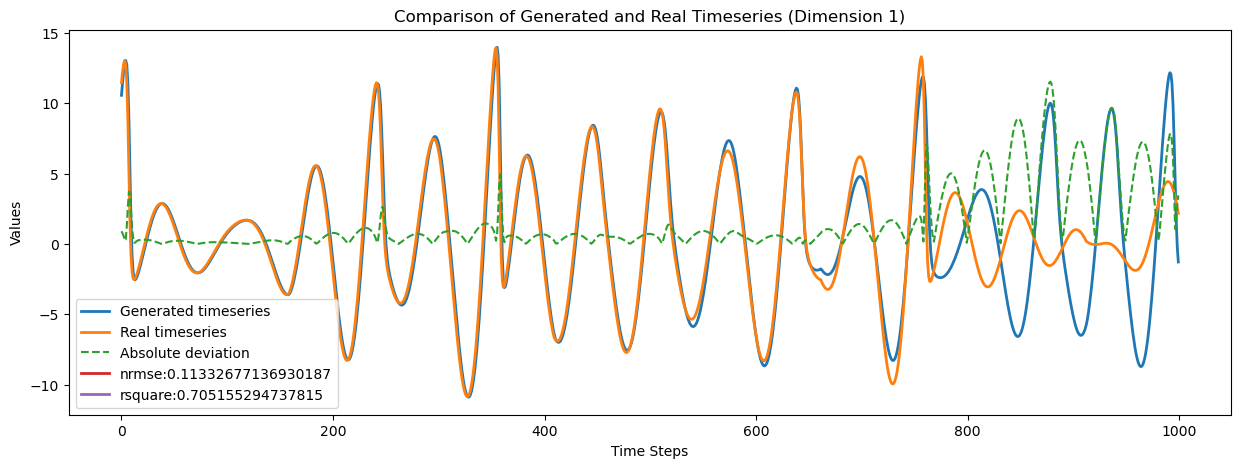

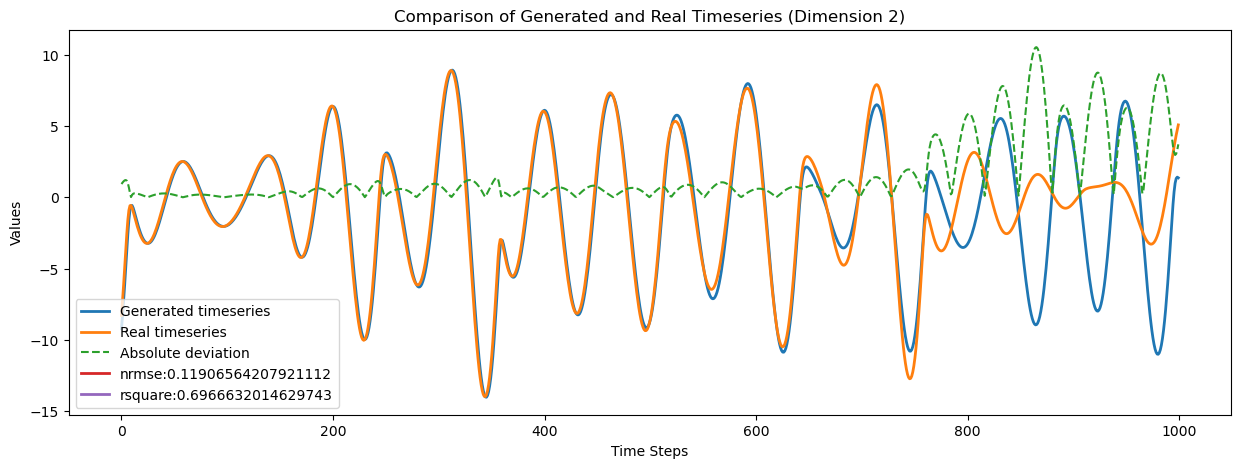

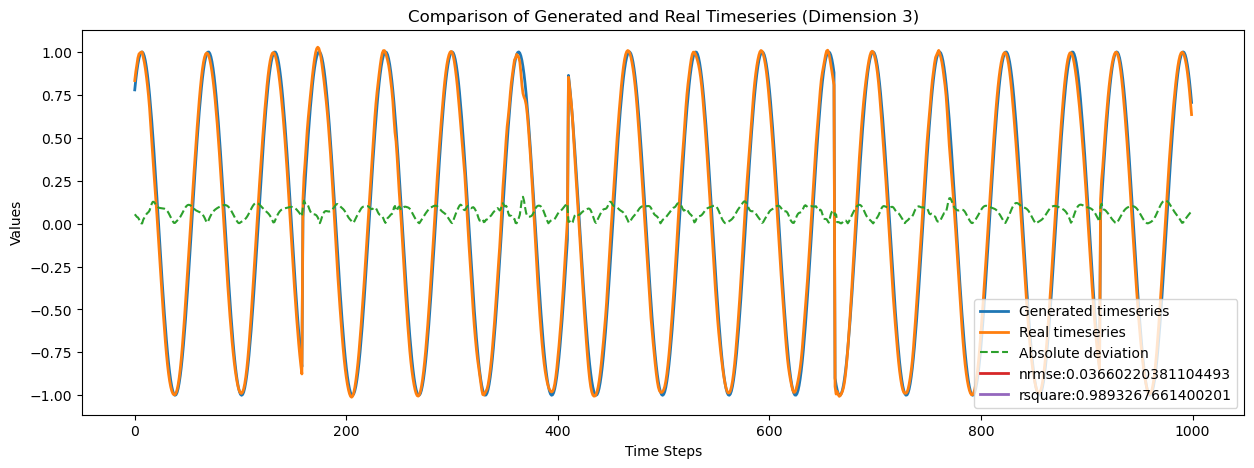

In [28]:
# 時系列データの比較を行う関数
def compare_timeseries_multidimensional(X_gen, X_t):
    num_dimensions = X_gen.shape[1]  # 次元数を取得
    for dim in range(num_dimensions):
        plt.figure(figsize=(15, 5))
        plt.plot(X_gen[:, dim][:1000], label="Generated timeseries", linewidth=2)
        plt.plot(X_t[:, dim][:1000], label="Real timeseries", linewidth=2)
        plt.plot(np.abs(X_t[:, dim][:1000] - X_gen[:, dim][:1000]), label="Absolute deviation", linestyle='--')
        plt.plot(nrmse(X_gen[:, dim][:1000], X_t[:, dim][:1000]), label=f"nrmse:{nrmse(X_gen[:, dim][:1000], X_t[:, dim][:1000])}", linewidth=2)
        plt.plot(rsquare(X_gen[:, dim][:1000], X_t[:, dim][:1000]), label=f"rsquare:{rsquare(X_gen[:, dim][:1000], X_t[:, dim][:1000])}", linewidth=2)

        plt.title(f'Comparison of Generated and Real Timeseries (Dimension {dim+1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()        
        plt.show()

# 使用例:
compare_timeseries_multidimensional(X_result_amp, X_val_amp)
